## Семинар 5: "Улучшение сходимости нейросетей"

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

### Часть 1: Инициализация весов

Будем использовать MNIST для обучения:

In [3]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 119MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 20.6MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 79.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.4MB/s]


In [4]:
images_train, labels_train = next(iter(train_loader))

In [5]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    break

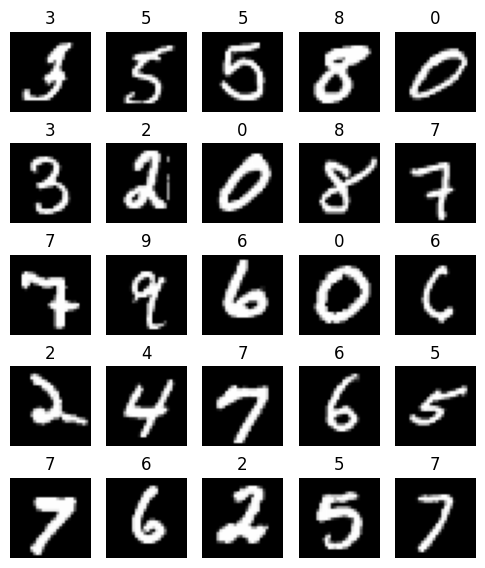

In [6]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

Создадим два линейных слоя и инициализируем их случайным образом. Для этого используем uniform распределение с нулевым средним и большим отклонением.

In [7]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

На вход передаем изображение 28x28, на выходе -- вероятности 10 классов.

In [8]:
layer_1 = nn.Linear(28*28, 256)
layer_2 = nn.Linear(256, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1)
init_layer(layer_2)

Соберем все вместе, используя ReLU в качестве функции активации:

In [9]:
network = nn.Sequential(
    layer_1,
    nn.ReLU(),
    layer_2
)

Посчитаем дисперсию активаций и диспресию градиентов:

In [10]:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

forward 0.9896661639213562
forward 16.08324432373047
backward 0.030550502240657806
backward 0.21133723855018616


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Теперь попробуем использовать инициализацию He:<br>
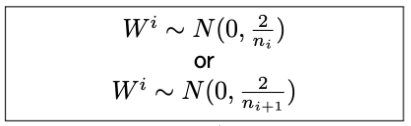

In [11]:
layer_1 = nn.Linear(28*28, 256)
layer_2 = nn.Linear(256, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1, 0, 2 / 256)
init_layer(layer_2, 0, 2 / 10)

In [12]:
network = nn.Sequential(
    layer_1,
    nn.ReLU(),
    layer_2
)

n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

forward 0.9896661639213562
forward 0.12424527853727341
backward 0.030550502240657806
backward 0.0375562459230423


## Часть 2: Dropout

Реализуем Dropout:

* Train: с вероятностью p занулим выход нейрона (например, p = 0.5)
* Test: домножаем веса на вероятность сохранения

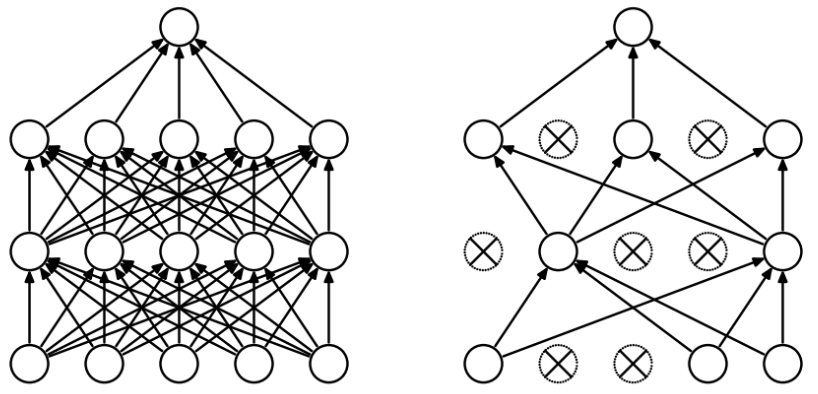


In [39]:
class Dropout(nn.Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        self.p = p

    def forward(self, x):
        mask = torch.empty(x.shape).uniform(0,1).type(torch.FloatTensor)
        if self.training:
            mask = torch.where(mask>self.p,1,0)
        else:
            mask = torch.where(mask>self.p,1,1-self.p)

        return x*mask

Основа для сети, которую будем обучать:

In [40]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()

        channels = 1

        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )

        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()

        self.final_part = final_part

        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

Добавим несколько слоев в конец сети:

In [41]:
layers = [
   nn.Linear(196,150),
   nn.ReLU(),
   nn.Dropout(),
   nn.Linear(150,50),
   nn.ReLU(),
   nn.Dropout(),
   nn.Linear(50,10)
]

In [42]:
network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

Обучим получившуюся сеть:

In [43]:
for epoch in range(10):
    network.train()
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer.zero_grad()
        X = images_train.data
        y = labels_train.data
        output = network(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

    network.eval()
    losses = []
    for batch_idx, (images_test, labels_test) in enumerate(test_loader):
        X = images_test.data
        y = labels_test.data
        output = network(X)
        loss = loss_fn(output, y)

        losses.append(loss.item())

    print('Test Epoch: {}\tLoss: {:.6f}'.format(
            epoch, np.mean(losses)))


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.305016
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.974740
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.588437
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.534721
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.384217
Test Epoch: 0	Loss: 0.202312
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.349000
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.318967
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.434042
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.340901
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.194305
Test Epoch: 1	Loss: 0.145912
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.182149
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.228977
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.266114
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.446392
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.095083
Test Epoch: 2	Loss: 0.109774
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.284438
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.259915
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.228536
Train Epoch: 3 [38400/60000 (64%)

ДЗ ОРЛОВА АННА АЛЕКСАНДРОВНА

#### 1.1 Реализуйте инициализацию Xavier. Сравните ее с He, которая была реализована на семинаре, сделайте выводы. Учтите, что для Xavier необходимо использовать функцию активации nn.Tanh(). **(1 балл)**


In [44]:
def xavier_init(layer):
    if layer.bias is not None:
      layer.bias.data.zero_()
    n_in = layer.weight.size(1)
    n_out = layer.weight.size(0)
    a = (6.0 / (n_in + n_out)) ** 0.5
    layer.weight.data.uniform_(-a, a)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

In [45]:
layer_1_xav = nn.Linear(28*28, 500)
layer_2_xav = nn.Linear(500, 10)

layer_1_xav.register_forward_hook(forward_hook)
layer_2_xav.register_forward_hook(forward_hook)

layer_1_xav.register_backward_hook(backward_hook)
layer_2_xav.register_backward_hook(backward_hook)
xavier_init(layer_1_xav)
xavier_init(layer_2_xav)

network_xav = nn.Sequential(
    layer_1_xav,
    nn.Tanh(),
    layer_2_xav
)

In [52]:
n_objects = 100
images_train, labels_train = next(iter(train_loader))
n_objects = min(n_objects, images_train.size(0))

X = images_train[:n_objects].view(n_objects, -1)
y = labels_train[:n_objects]
y = labels_train[:n_objects].data
activations = network_xav(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network_xav.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

forward 1.007419466972351
forward 0.6553894877433777
backward 0.03620927035808563
backward 0.012476122006773949


## Часть 2: DropConnect

#### 2.1 Реализуйте DropConnect по следующему шаблону: **(1 балл)**

In [33]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        if self.training:
            mask = torch.ones_like(self.linear.weight).bernoulli_(self.p)
            mask=mask / self.p #inverted dropout
        else:
            mask = torch.ones_like(self.linear.weight)

        mask = mask.data   # отключаем градиенты
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

Основа для сети, которую будем обучать:

In [34]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()

        channels = 1

        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )

        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()

        self.final_part = final_part

        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

Добавим несколько слоев в конец сети:

In [35]:
layers = [
   DropConnect(196,150,p=0.5),
   nn.ReLU(),
   DropConnect(150,50,p=0.5),
   nn.ReLU(),
   nn.Linear(50,10)
]

In [36]:
network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

Обучим получившуюся сеть:

In [38]:
for epoch in range(10):
    network.train()
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer.zero_grad()
        X = images_train.data
        y = labels_train.data
        output = network(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

    network.eval()
    losses = []
    for batch_idx, (images_test, labels_test) in enumerate(test_loader):
        X = images_test.data
        y = labels_test.data
        output = network(X)
        loss = loss_fn(output, y)

        losses.append(loss.item())

    print('Test Epoch: {}\tLoss: {:.6f}'.format(
            epoch, np.mean(losses)))


Train Epoch: 0 [0/60000 (0%)]	Loss: 0.230371
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.120118
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.210185
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.126132
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.213863
Test Epoch: 0	Loss: 0.096284
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.076538
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.267090
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.196217
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.087026
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.180922
Test Epoch: 1	Loss: 0.087380
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.132756
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.148382
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.219351
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.206198
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.149924
Test Epoch: 2	Loss: 0.084461
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.144417
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.082448
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.074056
Train Epoch: 3 [38400/60000 (64%)


#### 2.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и DropConnect вместо всех линейных слоев


In [59]:
def train_network(network, epochs=10):
    optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
    loss_fn = torch.nn.NLLLoss()

    train_losses_per_epoch = []
    test_losses_per_epoch = []

    for epoch in range(epochs):
        network.train()
        epoch_train_losses = []
        for batch_idx, (images_train, labels_train) in enumerate(train_loader):
            optimizer.zero_grad()
            X = images_train.data
            y = labels_train.data
            output = network(X)
            loss = loss_fn(output, y)
            loss.backward()
            optimizer.step()

            epoch_train_losses.append(loss.item())

            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(X), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))

        avg_train_loss = np.mean(epoch_train_losses)
        train_losses_per_epoch.append(avg_train_loss)

        network.eval()
        losses = []
        for batch_idx, (images_test, labels_test) in enumerate(test_loader):
            X = images_test.data
            y = labels_test.data
            output = network(X)
            loss = loss_fn(output, y)
            losses.append(loss.item())

        avg_test_loss = np.mean(losses)
        test_losses_per_epoch.append(avg_test_loss)
        print('Test Epoch: {}\tLoss: {:.6f}'.format(epoch, avg_test_loss))

    return train_losses_per_epoch, test_losses_per_epoch

In [54]:
layers_dropout = [
    nn.Linear(196, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 10)
]
net_dropout = TestNetwork(nn.Sequential(*layers_dropout))

In [55]:
layers_dropconnect = [
    DropConnect(196, 128, p=0.5),
    nn.ReLU(),
    DropConnect(128, 128, p=0.5),
    nn.ReLU(),
    DropConnect(128, 10, p=0.5)
]
net_dropconnect = TestNetwork(nn.Sequential(*layers_dropconnect))

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.353485
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.292347
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.286835
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.172490
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.236001
Test Epoch: 0	Loss: 0.127814
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.238377
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.282849
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.102298
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.309444
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.172202
Test Epoch: 1	Loss: 0.113413
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.098703
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.171710
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.089769
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.180227
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.167469
Test Epoch: 2	Loss: 0.106996
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.176507
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.288619
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.137489
Train Epoch: 3 [38400/60000 (64%)

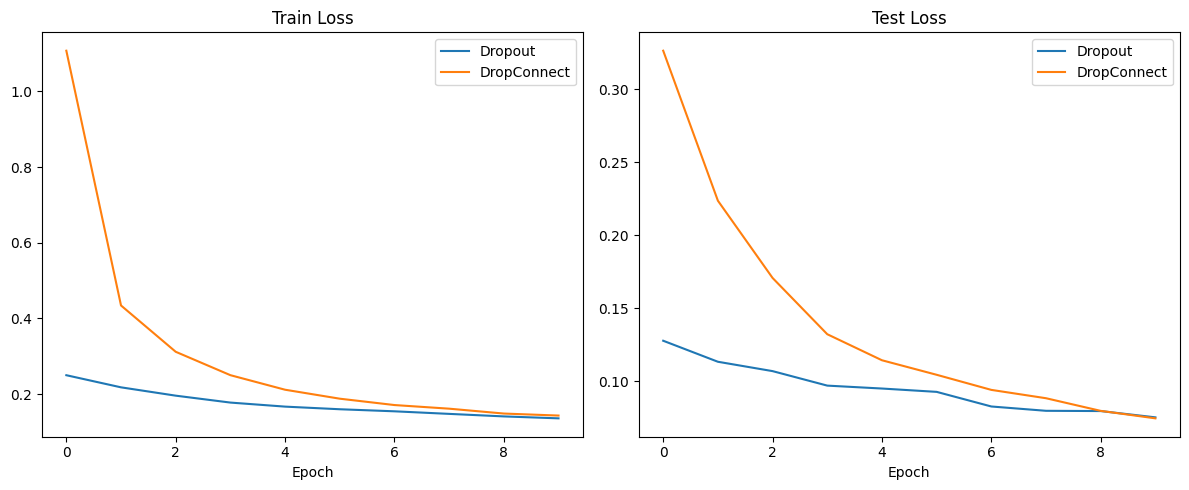

In [60]:
train_do, test_do = train_network(net_dropout, epochs=10)
train_dc, test_dc = train_network(net_dropconnect, epochs=10)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_do, label='Dropout')
plt.plot(train_dc, label='DropConnect')
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_do, label='Dropout')
plt.plot(test_dc, label='DropConnect')
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

#### 3.1 Реализуйте Layer Normalization **(1 балл)**
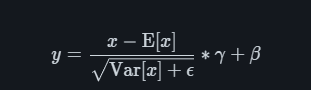

In [61]:
class LayerNormalization(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.eps = eps

    def forward(self, x):
        mean=x.mean(dim=-1,keepdim=True)
        std=x.std(dim=-1,keepdim=True,unbiased=False)
        x_norm=(x-mean)/(std + self.eps)
        if not hasattr(self, 'gamma') or self.gamma.size(-1) != x.size(-1):
            self.gamma = nn.Parameter(torch.ones(x.size(-1)))
            self.beta = nn.Parameter(torch.zeros(x.size(-1)))
        output = self.gamma * x_norm + self.beta
        return output

#### 3.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями

In [62]:
BatchNorm_layers = [
    nn.Linear(196, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),

    nn.Linear(128, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),

    nn.Linear(128, 10)
]
net_batch = TestNetwork(nn.Sequential(*BatchNorm_layers))

In [63]:
LayerNormalization_layers = [
    nn.Linear(196, 128),
    LayerNormalization(),
    nn.ReLU(),
    nn.Linear(128, 128),
    LayerNormalization(),
    nn.ReLU(),
    nn.Linear(128, 10)
]
net_layer = TestNetwork(nn.Sequential(*LayerNormalization_layers))

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.466678
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.272203
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.128015
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.086999
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.074893
Test Epoch: 0	Loss: 0.084431
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.059371
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.058610
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.157337
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.085502
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.129495
Test Epoch: 1	Loss: 0.061798
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.067971
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.084204
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.048584
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.039220
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.025559
Test Epoch: 2	Loss: 0.059476
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.020139
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.029972
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.042832
Train Epoch: 3 [38400/60000 (64%)

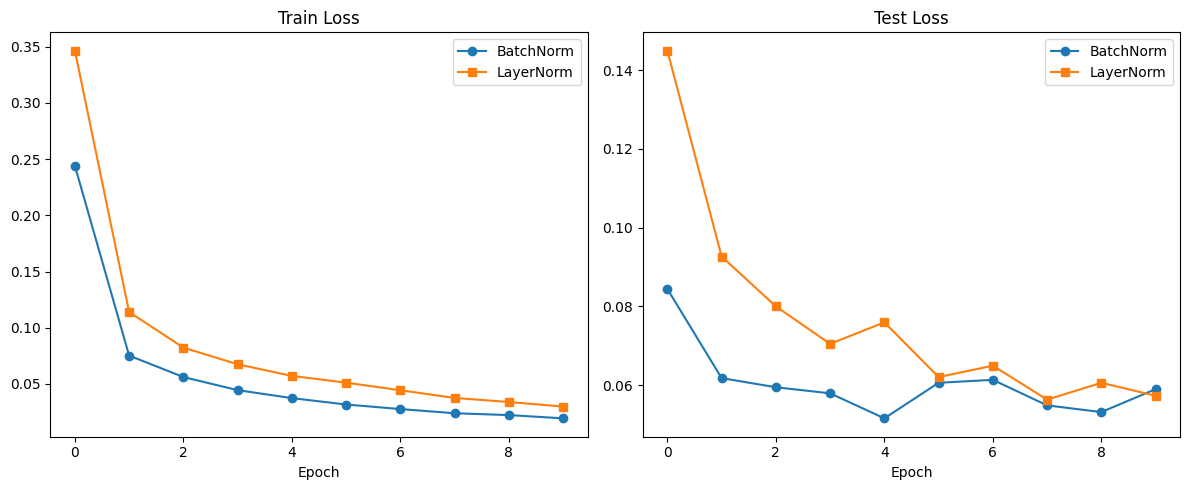

In [64]:
train_bn, test_bn = train_network(net_batch, epochs=10)
train_ln, test_ln = train_network(net_layer, epochs=10)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_bn, label='BatchNorm', marker='o')
plt.plot(train_ln, label='LayerNorm', marker='s')
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_bn, label='BatchNorm', marker='o')
plt.plot(test_ln, label='LayerNorm', marker='s')
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()